In [ ]:
# ═══════════════════════════════════════════════════════════════
# 📦 BLOQUE COMPLETO: Carga de datos + Análisis Pacífico vs Atlántico
# ═══════════════════════════════════════════════════════════════

# 1️⃣ IMPORTAR LIBRERÍAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS
import warnings
warnings.filterwarnings('ignore')

# Configuración visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 2️⃣ CARGAR DATOS (ajusta el nombre del archivo si es diferente)
try:
    df = pd.read_csv('peces_canal_panama_ML_limpio.csv')
    print("✅ Archivo cargado correctamente")
except FileNotFoundError:
    print("❌ ERROR: No encuentro el archivo CSV")
    print("   Sube el archivo con: from google.colab import files; files.upload()")
    raise

# 4️⃣ EXPLORACIÓN DE VERTIENTES
print("\n" + "="*60)
print("🔍 EXPLORACIÓN INICIAL - VERTIENTES:")
print("="*60)
print("\nConteo por vertiente:")
print(df_clean['Vertiente'].value_counts())

print("\nAmbientes por vertiente:")
print(pd.crosstab(df_clean['Vertiente'], df_clean['Ambiente']))

# 5️⃣ CREAR MATRIZ DE COMUNIDADES POR VERTIENTE
community_by_watershed = df_clean.groupby(['Vertiente', 'Especies'])['TOTAL'].sum().unstack(fill_value=0)

print(f"\n📊 Matriz de comunidades por vertiente:")
print(f"   Dimensiones: {community_by_watershed.shape}")
print(f"   (filas=vertientes, columnas=especies)")

# 6️⃣ CALCULAR DIVERSIDAD ALPHA
def simpson_diversity(row):
    N = row.sum()
    if N == 0:
        return 0
    p = row / N
    return 1 - (p**2).sum()

diversity_comparison = pd.DataFrame({
    'Vertiente': community_by_watershed.index,
    'Simpson': community_by_watershed.apply(simpson_diversity, axis=1),
    'Riqueza': (community_by_watershed > 0).sum(axis=1),
    'Abundancia_Total': community_by_watershed.sum(axis=1)
})

print("\n📈 DIVERSIDAD ALPHA POR VERTIENTE:")
print(diversity_comparison.to_string(index=False))

print("\n✅ Variables listas para análisis:")
print("   - df_clean")
print("   - community_by_watershed")
print("   - diversity_comparison")

✅ Archivo cargado correctamente

🔍 EXPLORACIÓN INICIAL - VERTIENTES:

Conteo por vertiente:
Vertiente
C    7289
P    5069
I    2923
A    2886
Name: count, dtype: int64

Ambientes por vertiente:
Ambiente      D     M
Vertiente            
A          2183   703
C          4329  2960
I          2923     0
P          1295  3774

📊 Matriz de comunidades por vertiente:
   Dimensiones: (4, 115)
   (filas=vertientes, columnas=especies)

📈 DIVERSIDAD ALPHA POR VERTIENTE:
Vertiente  Simpson  Riqueza  Abundancia_Total
        A 0.753125       17             45214
        C 0.878836       44             87394
        I 0.719264       12             55093
        P 0.907832       42             55463

✅ Variables listas para análisis:
   - df_clean
   - community_by_watershed
   - diversity_comparison


🧪 BLOQUE 2: PERMANOVA - Test Estadístico

In [ ]:
# PERMANOVA (Permutational Multivariate Analysis of Variance)
# Pregunta: ¿Las comunidades difieren significativamente entre vertientes?

from scipy.spatial.distance import pdist, squareform
from scipy.stats import f_oneway
import itertools

# Función para PERMANOVA (implementación simplificada)
def permanova_simple(distance_matrix, groups, n_permutations=999):
    """
    PERMANOVA de 1 vía usando Bray-Curtis

    Parámetros:
    - distance_matrix: matriz de distancias (squareform)
    - groups: vector de grupos (ej. ['P', 'P', 'C', 'C'])
    - n_permutations: número de permutaciones

    Retorna: F-estadístico, p-value
    """
    n = len(groups)
    unique_groups = np.unique(groups)

    # Calcular SS_total
    grand_centroid = distance_matrix.sum() / (n * (n - 1))
    SS_total = (distance_matrix ** 2).sum() / (2 * n)

    # Calcular SS_within (dentro de grupos)
    SS_within = 0
    for group in unique_groups:
        idx = np.where(groups == group)[0]
        if len(idx) > 1:
            group_dist = distance_matrix[np.ix_(idx, idx)]
            SS_within += (group_dist ** 2).sum() / (2 * len(idx))

    # SS_among (entre grupos)
    SS_among = SS_total - SS_within

    # Grados de libertad
    df_among = len(unique_groups) - 1
    df_within = n - len(unique_groups)

    # F-estadístico
    MS_among = SS_among / df_among
    MS_within = SS_within / df_within
    F_obs = MS_among / MS_within

    # Permutaciones para p-value
    F_perm = []
    for _ in range(n_permutations):
        groups_perm = np.random.permutation(groups)

        SS_within_perm = 0
        for group in unique_groups:
            idx = np.where(groups_perm == group)[0]
            if len(idx) > 1:
                group_dist = distance_matrix[np.ix_(idx, idx)]
                SS_within_perm += (group_dist ** 2).sum() / (2 * len(idx))

        SS_among_perm = SS_total - SS_within_perm
        MS_among_perm = SS_among_perm / df_among
        MS_within_perm = SS_within_perm / df_within
        F_perm.append(MS_among_perm / MS_within_perm)

    # Calcular p-value
    p_value = (np.sum(np.array(F_perm) >= F_obs) + 1) / (n_permutations + 1)

    return F_obs, p_value, SS_among / SS_total  # También retornamos R²

# Preparar datos para PERMANOVA
# Necesitamos expandir la matriz a nivel de AÑO × VERTIENTE para tener réplicas
community_year_watershed = df_clean.groupby(['AÑO', 'Vertiente', 'Especies'])['TOTAL'].sum().unstack(fill_value=0)

# Crear matriz de comunidades con años como réplicas
# (cada año es una "muestra" de cada vertiente)
community_matrix_perm = df_clean.groupby(['AÑO', 'Vertiente', 'Especies'])['TOTAL'].sum().unstack(fill_value=0)
community_matrix_perm = community_matrix_perm.fillna(0)

# Resetear índice para separar AÑO y VERTIENTE
community_matrix_perm = community_matrix_perm.reset_index()

print("🔬 PERMANOVA - Prueba de Hipótesis")
print("H0: No hay diferencia en composición entre vertientes")
print("H1: Las vertientes tienen composiciones diferentes\n")

# Calcular matriz de Bray-Curtis
from scipy.spatial.distance import pdist, squareform
bc_dist = pdist(community_matrix_perm.drop(['AÑO', 'Vertiente'], axis=1), metric='braycurtis')
bc_matrix_perm = squareform(bc_dist)

# Ejecutar PERMANOVA
groups = community_matrix_perm['Vertiente'].values
F_stat, p_val, r_squared = permanova_simple(bc_matrix_perm, groups, n_permutations=999)

print(f"📊 RESULTADOS PERMANOVA:")
print(f"   F-estadístico: {F_stat:.3f}")
print(f"   p-value: {p_val:.4f}")
print(f"   R² (varianza explicada): {r_squared:.3f}")

if p_val < 0.05:
    print(f"\n✅ CONCLUSIÓN: Las comunidades SÍ difieren significativamente (p < 0.05)")
else:
    print(f"\n❌ CONCLUSIÓN: No hay evidencia de diferencia (p ≥ 0.05)")

🔬 PERMANOVA - Prueba de Hipótesis
H0: No hay diferencia en composición entre vertientes
H1: Las vertientes tienen composiciones diferentes

📊 RESULTADOS PERMANOVA:
   F-estadístico: 9.270
   p-value: 0.0010
   R² (varianza explicada): 0.410

✅ CONCLUSIÓN: Las comunidades SÍ difieren significativamente (p < 0.05)


🗺️ BLOQUE 3: NMDS con Separación por Vertiente

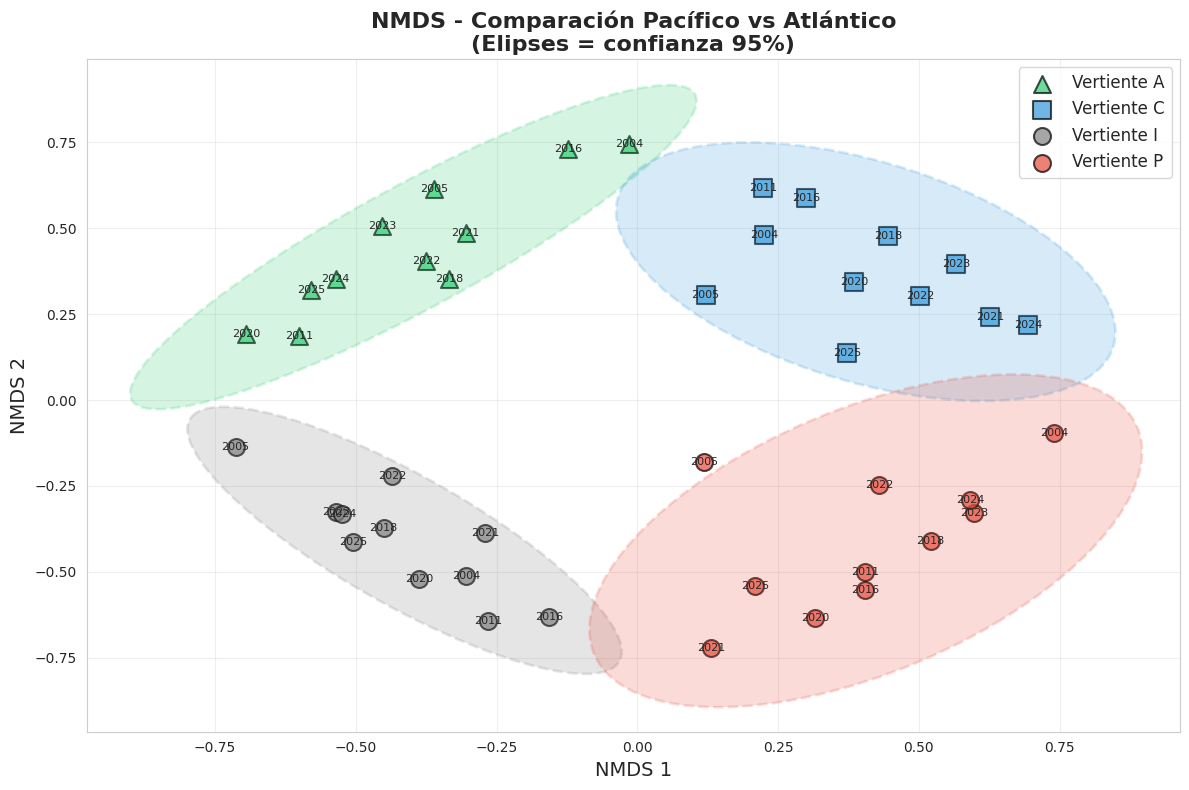


📏 Stress del NMDS: 91.798
   ⚠️ Stress alto - considerar 3D o interpretar con cautela


In [ ]:
from sklearn.manifold import MDS
from matplotlib.colors import Normalize
from matplotlib.patches import Ellipse

# Calcular NMDS usando la matriz año×vertiente
bc_matrix_nmds = squareform(pdist(community_matrix_perm.drop(['AÑO', 'Vertiente'], axis=1),
                                   metric='braycurtis'))

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
nmds_coords = mds.fit_transform(bc_matrix_nmds)

# Visualizar con colores por vertiente
fig, ax = plt.subplots(figsize=(12, 8))

vertientes = community_matrix_perm['Vertiente'].values
years = community_matrix_perm['AÑO'].values
unique_vertientes = np.unique(vertientes)

# Paleta de colores por vertiente
colors_map = {'P': '#e74c3c', 'C': '#3498db', 'A': '#2ecc71', 'AC': '#9b59b6'}  # Rojo=Pacífico, Azul=Caribe
markers = {'P': 'o', 'C': 's', 'A': '^', 'AC': 'D'}

# Plotear puntos
for vert in unique_vertientes:
    idx = vertientes == vert
    ax.scatter(nmds_coords[idx, 0], nmds_coords[idx, 1],
               c=colors_map.get(vert, 'gray'),
               marker=markers.get(vert, 'o'),
               s=150, alpha=0.7, edgecolor='black', linewidth=1.5,
               label=f"Vertiente {vert}")

    # Agregar etiquetas de año
    for i, (x, y, year) in enumerate(zip(nmds_coords[idx, 0],
                                          nmds_coords[idx, 1],
                                          years[idx])):
        ax.text(x, y, str(year), fontsize=8, ha='center', va='center')

# Calcular y dibujar elipses de confianza (95%)
from matplotlib.patches import Ellipse

for vert in unique_vertientes:
    idx = vertientes == vert
    points = nmds_coords[idx]

    if len(points) > 2:  # Necesita al menos 3 puntos
        # Calcular centroide y covarianza
        centroid = points.mean(axis=0)
        cov = np.cov(points.T)

        # Eigenvalores para ejes de elipse
        eigenvalues, eigenvectors = np.linalg.eig(cov)
        angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))

        # Dibujar elipse (95% confianza = 2.45 desviaciones estándar)
        width, height = 2.45 * 2 * np.sqrt(eigenvalues)
        ellipse = Ellipse(centroid, width, height, angle=angle,
                         facecolor=colors_map.get(vert, 'gray'),
                         alpha=0.2, edgecolor=colors_map.get(vert, 'gray'),
                         linewidth=2, linestyle='--')
        ax.add_patch(ellipse)

ax.set_xlabel('NMDS 1', fontsize=14)
ax.set_ylabel('NMDS 2', fontsize=14)
ax.set_title('NMDS - Comparación Pacífico vs Atlántico\n(Elipses = confianza 95%)',
             fontsize=16, fontweight='bold')
ax.grid(alpha=0.3)
ax.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\n📏 Stress del NMDS: {mds.stress_:.3f}")
if mds.stress_ < 0.1:
    print("   ✅ Excelente representación 2D")
elif mds.stress_ < 0.2:
    print("   ✅ Buena representación 2D")
else:
    print("   ⚠️ Stress alto - considerar 3D o interpretar con cautela")

🐟 BLOQUE 4: Especies Indicadoras (IndVal)

🏆 TOP 10 ESPECIES INDICADORAS POR VERTIENTE

(IndVal > 0.3 sugiere buena indicadora)


VERTIENTE A:
Astyanax ruberrimus Eigenmann, 1913                IndVal=0.909
Mugil curema Valenciennes, 1836                    IndVal=0.636
Hoplias microlepis (Günther, 1864)                 IndVal=0.636
Poecilia gillii (Kner, 1863)                       IndVal=0.545
Awaous banana (Valenciennes, 1837)                 IndVal=0.455
Oligoplites saurus (Bloch & Schneider, 1801)       IndVal=0.273
Pterygoplichthys pardalis (Castelnau, 1855)        IndVal=0.273
Synbranchus marmoratus Bloch, 1795                 IndVal=0.273
Poeciliopsis turrubarensis (Meek, 1912)            IndVal=0.182
Eleotris pisonis (Gmelin, 1789)                    IndVal=0.182

VERTIENTE C:
Gobiomorus dormitor Lacepède, 1800                 IndVal=1.000
Vieja maculicauda (Regan, 1905)                    IndVal=1.000
Brycon chagrensis (Kner, 1863)                     IndVal=0.818
Eugerres plumieri (Cuvier, 1830)                   Ind

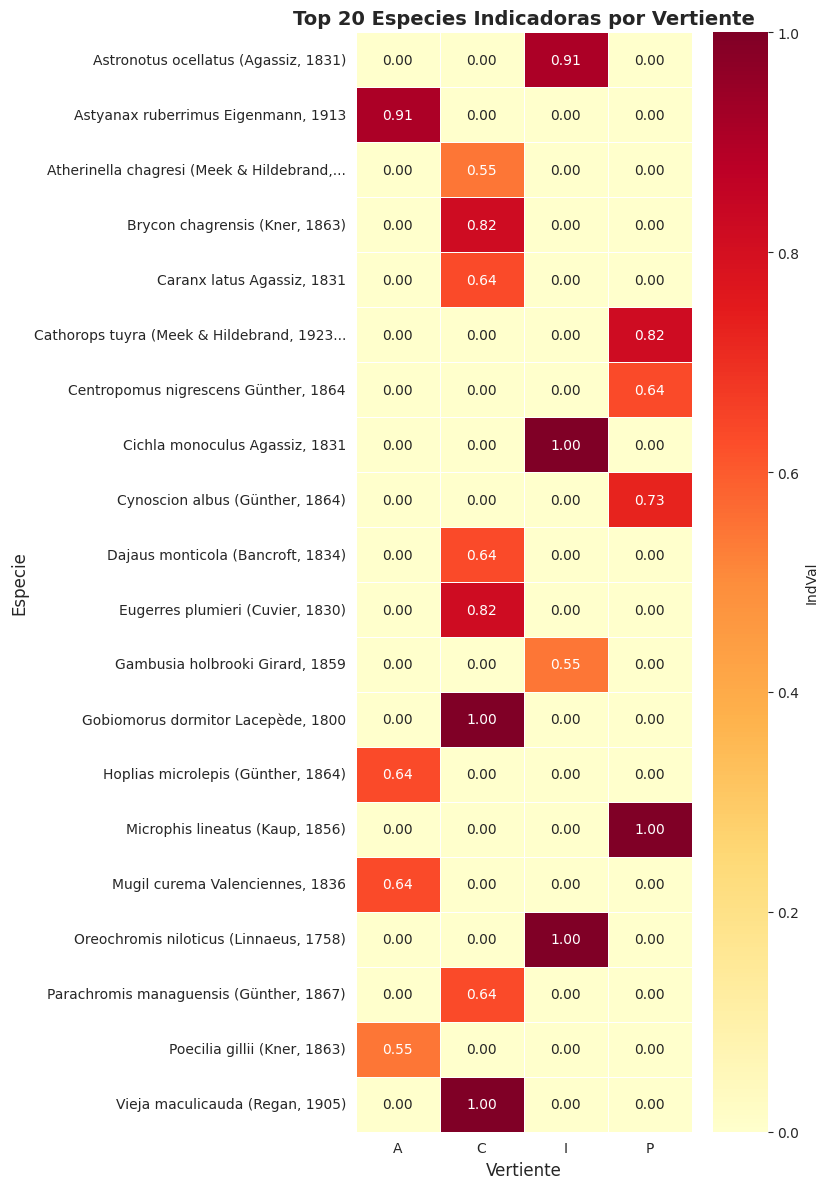

In [ ]:
# Identificar especies indicadoras de cada vertiente
# IndVal = Especificidad × Fidelidad

def calculate_indval(species_data, groups):
    """
    Calcula índice IndVal para especies indicadoras

    Parámetros:
    - species_data: DataFrame con especies como columnas, muestras como filas
    - groups: vector de grupos (vertientes)

    Retorna: DataFrame con IndVal por especie y grupo
    """
    results = []
    unique_groups = np.unique(groups)

    for species in species_data.columns:
        abundances = species_data[species].values

        for group in unique_groups:
            group_idx = groups == group

            # Especificidad: proporción de individuos de la especie en el grupo
            total_in_group = abundances[group_idx].sum()
            total_species = abundances.sum()
            specificity = total_in_group / total_species if total_species > 0 else 0

            # Fidelidad: proporción de muestras del grupo donde está presente
            presence_in_group = (abundances[group_idx] > 0).sum()
            total_samples_group = group_idx.sum()
            fidelity = presence_in_group / total_samples_group if total_samples_group > 0 else 0

            # IndVal
            indval = specificity * fidelity

            results.append({
                'Especie': species,
                'Vertiente': group,
                'IndVal': indval,
                'Especificidad': specificity,
                'Fidelidad': fidelity,
                'Abundancia_Total': abundances.sum()
            })

    return pd.DataFrame(results)

# Calcular IndVal
species_matrix = community_matrix_perm.drop(['AÑO', 'Vertiente'], axis=1)
groups_indval = community_matrix_perm['Vertiente'].values

indval_results = calculate_indval(species_matrix, groups_indval)

# Seleccionar top especies por vertiente
print("🏆 TOP 10 ESPECIES INDICADORAS POR VERTIENTE\n")
print("(IndVal > 0.3 sugiere buena indicadora)\n")

for vert in np.unique(groups_indval):
    top_species = indval_results[indval_results['Vertiente'] == vert].sort_values('IndVal', ascending=False).head(10)

    print(f"\n{'='*60}")
    print(f"VERTIENTE {vert}:")
    print(f"{'='*60}")

    for i, row in top_species.iterrows():
        print(f"{row['Especie'][:50]:<50} IndVal={row['IndVal']:.3f}")

# Visualización: Heatmap de especies indicadoras
top_indicators = indval_results.sort_values('IndVal', ascending=False).head(20)

# Crear matriz para heatmap
heatmap_data = top_indicators.pivot_table(
    values='IndVal',
    index='Especie',
    columns='Vertiente',
    fill_value=0
)

# Truncar nombres de especies
heatmap_data.index = [sp[:40] + '...' if len(sp) > 40 else sp for sp in heatmap_data.index]

plt.figure(figsize=(8, 12))
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='YlOrRd',
            cbar_kws={'label': 'IndVal'}, linewidths=0.5)
plt.title('Top 20 Especies Indicadoras por Vertiente', fontsize=14, fontweight='bold')
plt.xlabel('Vertiente', fontsize=12)
plt.ylabel('Especie', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# RESUMEN DE RESULTADOS
print("\n" + "="*70)
print(" 🌊 RESUMEN: COMPARACIÓN PACÍFICO VS ATLÁNTICO")
print("="*70)

print(f"\n1️⃣ DIVERSIDAD ALPHA:")
print(diversity_comparison.to_string(index=False))

print(f"\n2️⃣ PERMANOVA (Composición):")
print(f"   F = {F_stat:.3f}, p = {p_val:.4f}, R² = {r_squared:.3f}")
print(f"   Interpretación: {'Comunidades diferentes ✓' if p_val < 0.05 else 'Sin diferencia ✗'}")

print(f"\n3️⃣ NMDS:")
print(f"   Stress = {mds.stress_:.3f} ({'Buena representación' if mds.stress_ < 0.2 else 'Revisar'})")

print(f"\n4️⃣ ESPECIES INDICADORAS:")
for vert in np.unique(groups_indval):
    top_sp = indval_results[indval_results['Vertiente'] == vert].sort_values('IndVal', ascending=False).head(3)
    print(f"\n   Vertiente {vert}:")
    for _, row in top_sp.iterrows():
        print(f"      • {row['Especie'][:45]} (IndVal={row['IndVal']:.2f})")

print("\n" + "="*70)


 🌊 RESUMEN: COMPARACIÓN PACÍFICO VS ATLÁNTICO

1️⃣ DIVERSIDAD ALPHA:
Vertiente  Simpson  Riqueza  Abundancia_Total
        A 0.753125       17             45214
        C 0.878836       44             87394
        I 0.719264       12             55093
        P 0.907832       42             55463

2️⃣ PERMANOVA (Composición):
   F = 9.270, p = 0.0010, R² = 0.410
   Interpretación: Comunidades diferentes ✓

3️⃣ NMDS:
   Stress = 91.798 (Revisar)

4️⃣ ESPECIES INDICADORAS:

   Vertiente A:
      • Astyanax ruberrimus Eigenmann, 1913 (IndVal=0.91)
      • Mugil curema Valenciennes, 1836 (IndVal=0.64)
      • Hoplias microlepis (Günther, 1864) (IndVal=0.64)

   Vertiente C:
      • Gobiomorus dormitor Lacepède, 1800 (IndVal=1.00)
      • Vieja maculicauda (Regan, 1905) (IndVal=1.00)
      • Brycon chagrensis (Kner, 1863) (IndVal=0.82)

   Vertiente I:
      • Cichla monoculus Agassiz, 1831 (IndVal=1.00)
      • Oreochromis niloticus (Linnaeus, 1758) (IndVal=1.00)
      • Astronotus ocell